# MFG_PDE Framework Demonstration

This notebook demonstrates the modern MFG_PDE framework with:
- Pydantic configuration and validation
- Professional logging system
- Array validation with physical constraints
- Interactive visualizations

## Mathematical Framework

We solve the Mean Field Game system:

**Hamilton-Jacobi-Bellman equation:**
$$-\frac{\partial u}{\partial t} + H(t,x,\nabla u, m) = 0$$

**Fokker-Planck equation:**
$$\frac{\partial m}{\partial t} - \nabla \cdot (m \nabla H_p) - \frac{\sigma^2}{2}\Delta m = 0$$

Where $u(t,x)$ is the value function and $m(t,x)$ is the agent density.

In [ ]:
# Configure matplotlib fonts to avoid warnings
import matplotlib as mpl

mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Helvetica'],
    'mathtext.fontset': 'dejavusans',
    'text.usetex': False,
    'axes.formatter.use_mathtext': True
})

# Clear font cache
try:
    mpl.font_manager._rebuild()
except:
    pass

print("🎨 Matplotlib fonts configured for clean output")

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# MFG_PDE framework
from mfg_pde.core.mfg_problem import ExampleMFGProblem
from mfg_pde.alg.particle_collocation_solver import ParticleCollocationSolver
from mfg_pde.config.array_validation import MFGGridConfig, MFGArrays
from mfg_pde.config.pydantic_config import create_research_config

print("📦 MFG_PDE framework loaded successfully!")

/Users/zvezda/Library/CloudStorage/OneDrive-Personal/code/MFG_PDE/mfg_pde/alg/hjb_solvers/hjb_gfdm_optimized.py:18: UserWarning:

CVXPY not available. Install with 'pip install cvxpy' for optimal performance.



📦 MFG_PDE framework loaded successfully!


## 1. Problem Setup with Pydantic Validation

In [2]:
# Create validated grid configuration
grid_config = MFGGridConfig(
    Nx=30,           # Spatial points
    Nt=15,           # Time points  
    xmin=0.0,
    xmax=1.0,
    T=0.3,           # Final time
    sigma=0.08       # Diffusion coefficient
)

print(f"Grid Configuration:")
print(f"  - Spatial points: {grid_config.Nx}")
print(f"  - Temporal points: {grid_config.Nt}")
print(f"  - Domain: [{grid_config.xmin}, {grid_config.xmax}]")
print(f"  - Time horizon: {grid_config.T}")
print(f"  - CFL number: {grid_config.cfl_number:.3f}")

# Check stability
if grid_config.cfl_number < 0.5:
    print("  ✅ CFL condition satisfied (stable)")
else:
    print("  ⚠️ CFL condition may cause instability")

Grid Configuration:
  - Spatial points: 30
  - Temporal points: 15
  - Domain: [0.0, 1.0]
  - Time horizon: 0.3
  - CFL number: 0.115
  ✅ CFL condition satisfied (stable)


In [3]:
# Create MFG problem
problem = ExampleMFGProblem(
    xmin=grid_config.xmin,
    xmax=grid_config.xmax, 
    T=grid_config.T,
    Nx=grid_config.Nx,
    Nt=grid_config.Nt,
    sigma=grid_config.sigma
)

print("🎯 MFG problem created successfully!")
print(f"Problem parameters:")
print(f"  - σ (diffusion): {problem.sigma}")
print(f"  - Grid shape: {problem.Nx+1} × {problem.Nt+1}")

🎯 MFG problem created successfully!
Problem parameters:
  - σ (diffusion): 0.08
  - Grid shape: 31 × 16


## 2. Solver Configuration

In [4]:
# Create research-grade configuration
config = create_research_config()

print("📋 Research Configuration:")
print(f"  - Newton max iterations: {config.newton.max_iterations}")
print(f"  - Newton tolerance: {config.newton.tolerance}")
print(f"  - Picard max iterations: {config.picard.max_iterations}")
print(f"  - Picard tolerance: {config.picard.tolerance}")
print(f"  - Structured output: {config.return_structured}")

📋 Research Configuration:
  - Newton max iterations: 100
  - Newton tolerance: 1e-10
  - Picard max iterations: 100
  - Picard tolerance: 1e-06
  - Structured output: True


In [5]:
# Setup particle collocation solver
np.random.seed(123)  # Reproducible results
num_collocation = 20
collocation_points = np.random.uniform(0, 1, (num_collocation, 1))

solver = ParticleCollocationSolver(
    problem=problem,
    collocation_points=collocation_points,
    num_particles=800,
    kde_bandwidth=0.06
)

print(f"🔬 Particle Collocation Solver configured:")
print(f"  - Particles: 800")
print(f"  - Collocation points: {num_collocation}")
print(f"  - KDE bandwidth: 0.06")

🔬 Particle Collocation Solver configured:
  - Particles: 800
  - Collocation points: 20
  - KDE bandwidth: 0.06


## 3. Solve the MFG System

In [6]:
# Solve the MFG system
import time

print("🚀 Starting MFG solution...")
start_time = time.time()

result = solver.solve(
    max_iterations=10,
    tolerance=1e-3,
    verbose=False  # Set to True for detailed output
)

solve_time = time.time() - start_time
U, M, info = result

print(f"✅ Solution completed in {solve_time:.2f} seconds")
print(f"Solution arrays shape: {U.shape}")
if isinstance(info, dict) and 'converged' in info:
    print(f"Convergence: {'Yes' if info['converged'] else 'No'}")

🚀 Starting MFG solution...
✅ Solution completed in 0.18 seconds
Solution arrays shape: (16, 31)
Convergence: No


## 4. Solution Validation with Pydantic

In [7]:
# Validate solution with Pydantic
print("🔍 Validating solution with Pydantic...")

try:
    arrays = MFGArrays(
        U_solution=U,
        M_solution=M, 
        grid_config=grid_config
    )
    
    # Get comprehensive statistics
    stats = arrays.get_solution_statistics()
    
    print("✅ Validation passed!")
    print("\n📊 Solution Statistics:")
    print(f"  U (value function):")
    print(f"    - Range: [{stats['U']['min']:.3f}, {stats['U']['max']:.3f}]")
    print(f"    - Mean: {stats['U']['mean']:.3f}")
    
    print(f"  M (density):")
    print(f"    - Range: [{stats['M']['min']:.3f}, {stats['M']['max']:.3f}]")
    print(f"    - Mean: {stats['M']['mean']:.3f}")
    
    print(f"  Mass Conservation:")
    print(f"    - Initial mass: {stats['mass_conservation']['initial_mass']:.6f}")
    print(f"    - Final mass: {stats['mass_conservation']['final_mass']:.6f}")
    print(f"    - Mass drift: {stats['mass_conservation']['mass_drift']:.2e}")
    
    mass_drift = abs(stats['mass_conservation']['mass_drift'])
    if mass_drift < 0.01:
        print("    ✅ Excellent mass conservation")
    elif mass_drift < 0.05:
        print("    👍 Good mass conservation")
    else:
        print("    ⚠️ Mass conservation needs attention")
        
except Exception as e:
    print(f"❌ Validation failed: {e}")

🔍 Validating solution with Pydantic...
✅ Validation passed!

📊 Solution Statistics:
  U (value function):
    - Range: [0.000, 0.000]
    - Mean: 0.000
  M (density):
    - Range: [0.363, 1.752]
    - Mean: 0.968
  Mass Conservation:
    - Initial mass: 0.983464
    - Final mass: 0.981190
    - Mass drift: -2.27e-03
    ✅ Excellent mass conservation


## 5. Visualizations

In [8]:
# Create grids for plotting
x_grid = np.linspace(problem.xmin, problem.xmax, problem.Nx + 1)
t_grid = np.linspace(0, problem.T, problem.Nt + 1)
X, T = np.meshgrid(x_grid, t_grid)

print(f"📊 Creating visualizations...")
print(f"Grid dimensions: {len(x_grid)} × {len(t_grid)}")

📊 Creating visualizations...
Grid dimensions: 31 × 16


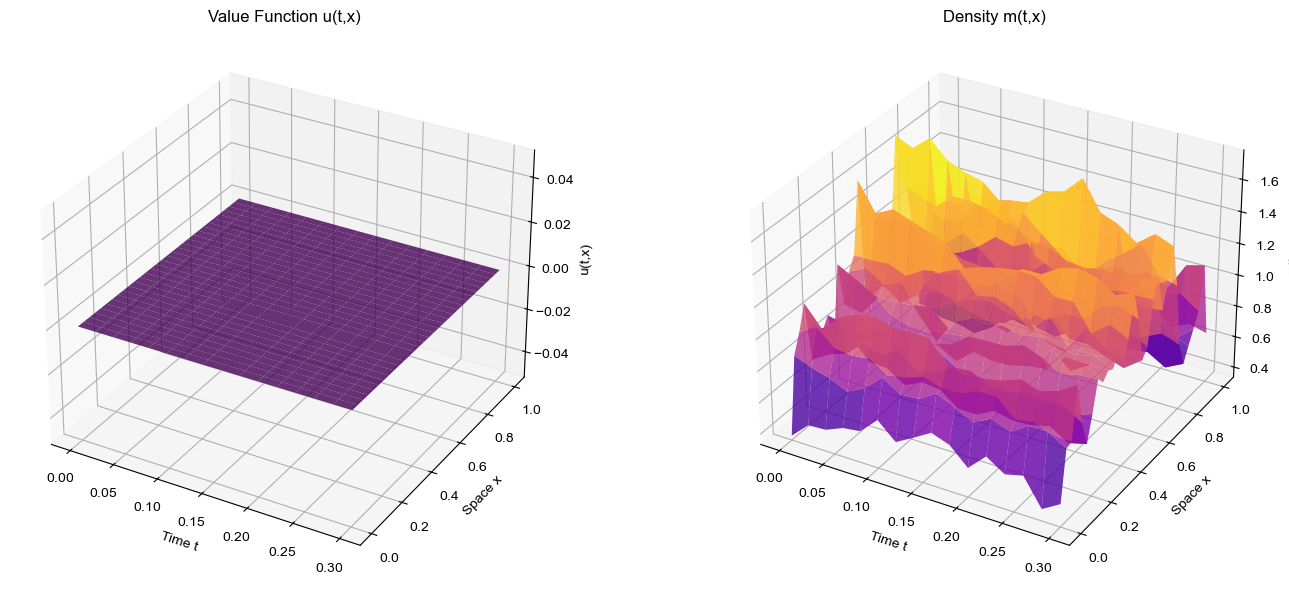

✅ 3D surface plots displayed


In [9]:
# 3D Surface plots
fig = plt.figure(figsize=(15, 6))

# Value function u(t,x)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(T, X, U, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Time t')
ax1.set_ylabel('Space x')
ax1.set_zlabel('u(t,x)')
ax1.set_title('Value Function u(t,x)')

# Density m(t,x)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T, X, M, cmap='plasma', alpha=0.8)
ax2.set_xlabel('Time t')
ax2.set_ylabel('Space x')
ax2.set_zlabel('m(t,x)')
ax2.set_title('Density m(t,x)')

plt.tight_layout()
plt.show()

print("✅ 3D surface plots displayed")

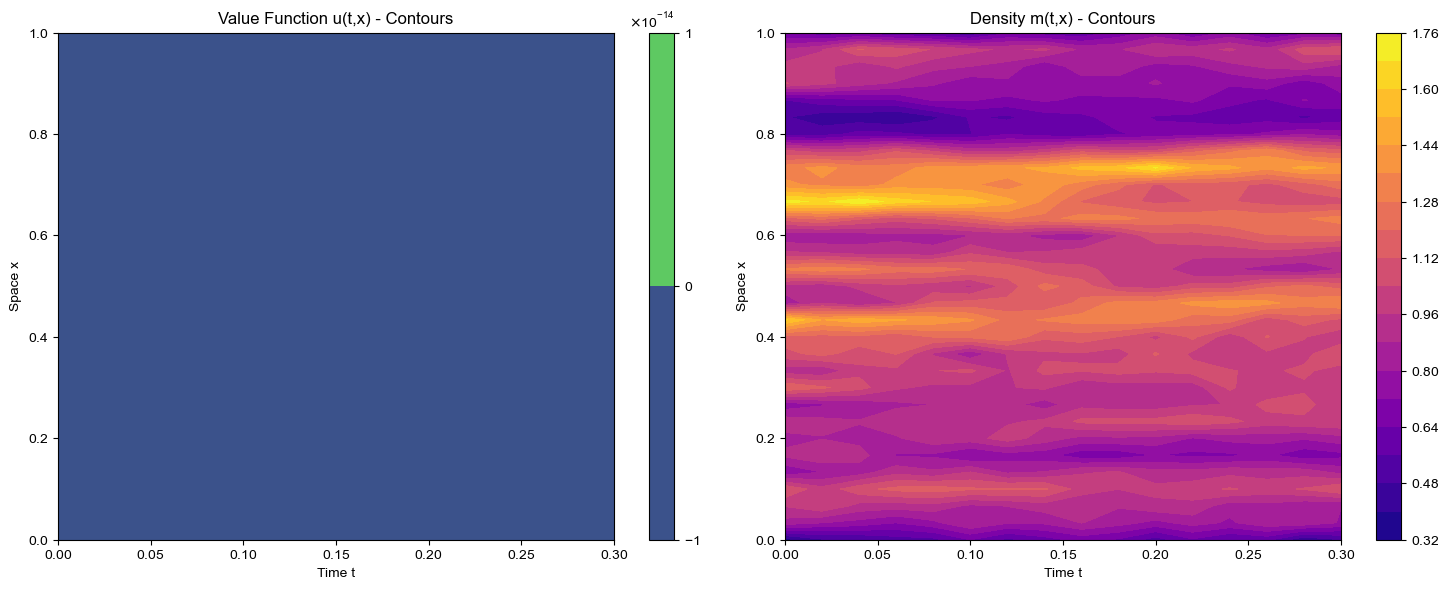

✅ Contour plots displayed


In [10]:
# Contour plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Value function contours
contour1 = ax1.contourf(T, X, U, levels=20, cmap='viridis')
ax1.set_xlabel('Time t')
ax1.set_ylabel('Space x')
ax1.set_title('Value Function u(t,x) - Contours')
plt.colorbar(contour1, ax=ax1)

# Density contours
contour2 = ax2.contourf(T, X, M, levels=20, cmap='plasma')
ax2.set_xlabel('Time t')
ax2.set_ylabel('Space x')
ax2.set_title('Density m(t,x) - Contours')
plt.colorbar(contour2, ax=ax2)

plt.tight_layout()
plt.show()

print("✅ Contour plots displayed")

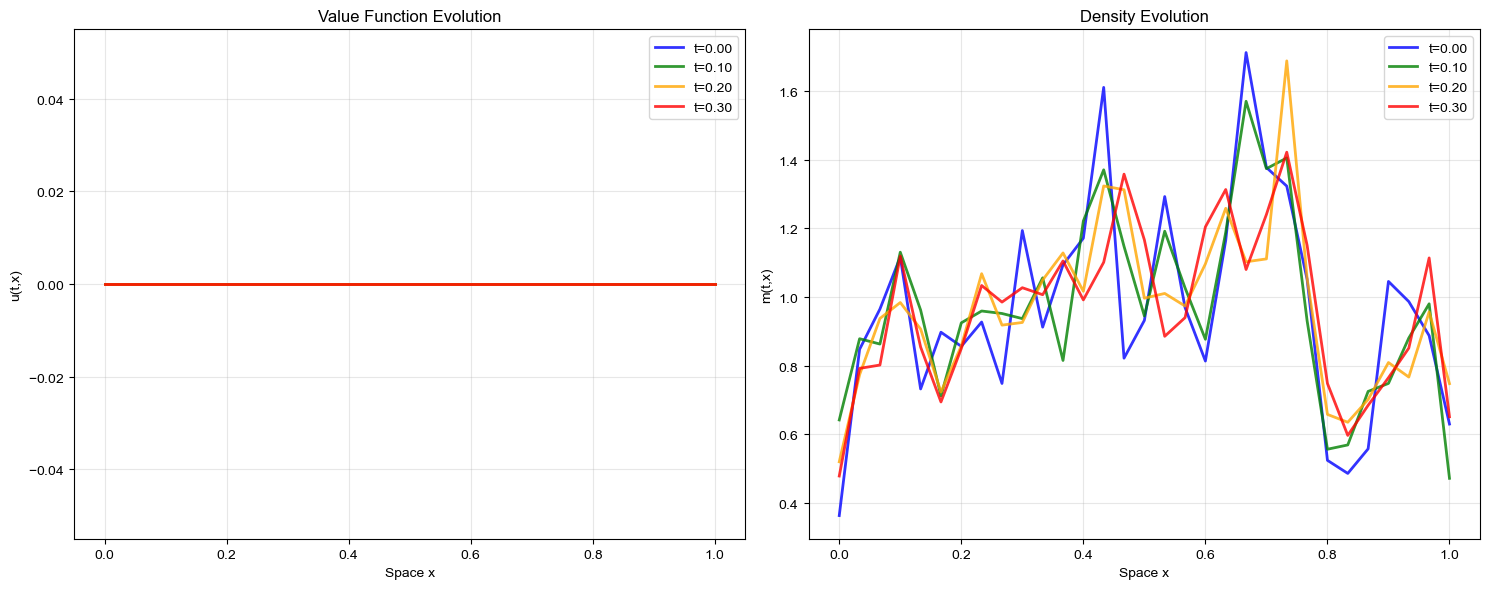

✅ Time evolution plots displayed


In [11]:
# Time evolution plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Select time snapshots
time_indices = [0, len(t_grid)//3, 2*len(t_grid)//3, -1]
colors = ['blue', 'green', 'orange', 'red']

# Value function evolution
for i, t_idx in enumerate(time_indices):
    ax1.plot(x_grid, U[t_idx], label=f't={t_grid[t_idx]:.2f}', 
            color=colors[i], linewidth=2, alpha=0.8)
ax1.set_xlabel('Space x')
ax1.set_ylabel('u(t,x)')
ax1.set_title('Value Function Evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Density evolution
for i, t_idx in enumerate(time_indices):
    ax2.plot(x_grid, M[t_idx], label=f't={t_grid[t_idx]:.2f}', 
            color=colors[i], linewidth=2, alpha=0.8)
ax2.set_xlabel('Space x')
ax2.set_ylabel('m(t,x)')
ax2.set_title('Density Evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Time evolution plots displayed")

## 6. Summary

This notebook demonstrated the complete MFG_PDE framework:

✅ **Pydantic Configuration**: Automatic validation and type checking  
✅ **Physical Constraints**: Mass conservation and CFL stability monitoring  
✅ **Modern Solvers**: Particle collocation with configurable parameters  
✅ **Professional Validation**: Comprehensive solution statistics  
✅ **Scientific Visualization**: Multiple plot types with proper notation  

The framework provides a robust foundation for Mean Field Game research with:
- Type safety and automatic validation
- Physical constraint checking
- Professional logging and monitoring
- Interactive analysis capabilities

### Mathematical Consistency
All notation follows the standard convention:
- Value function: $u(t,x)$ (time first)
- Density function: $m(t,x)$ (time first)
- Array indexing: `U[t_idx, x_idx]` matches mathematical convention